In [1]:
import re
from pathlib import Path
from itertools import combinations

import seaborn as sns
import opinionated  # noqa
import colormaps as cmaps
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from scipy.stats import f_oneway, ttest_ind, kendalltau, spearmanr, pearsonr

plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Data dir
data_dir = (
    Path("~/active/dg-uoi/data/per-day-release-content-metrics-one-year-rated/")
    .expanduser()
    .resolve()
    .absolute()
)

# Read all files with pandas and concat
df = pd.concat(pd.read_parquet(f) for f in data_dir.glob("*.parquet"))

# Convert to polars
df = pl.DataFrame(df)

# Lowercase all column names
df = df.select(pl.all().reverse().name.to_lowercase())

# Remove repo_name, repo_topics, release_content
df = df.drop(
    [
        "repo_name",
        "repo_topics",
        "repo_description",
        "release_content",
    ]
)

# Remove any rows with "complexity_rating" == "null"
df = df.filter(pl.col("complexity_rating") != "null")

# Cast complexity_rating to int
df = df.with_columns(pl.col("complexity_rating").cast(pl.Int32))

print(df.shape)

df.sample(3)

(848, 31)


release_name,repo_created_date,package_managers,release_version,release_major_version,release_minor_version,release_patch_version,release_type,publish_datetime,publish_date,num_dependencies,num_stars_day_of_release,num_public_forks_day_of_release,num_dependents_on_release_date,num_dependents_plus_90_days,num_stars_plus_90_days,num_forks_plus_90_days,num_dependents_plus_180_days,num_stars_plus_180_days,num_forks_plus_180_days,num_dependents_plus_270_days,num_stars_plus_270_days,num_forks_plus_270_days,num_dependents_plus_360_days,num_stars_plus_360_days,num_forks_plus_360_days,repo_language,repository_uuid,required_skills,reasoning,complexity_rating
str,str,str,str,f64,f64,f64,str,datetime[ns],str,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,i32
"""V0.3.0""","""2016-09-13""","""pypi""","""0.3.0""",3.0,0.0,null,"""zero-major""",2022-08-23 09:15:35,"""2022-08-23""",1,160.0,22,0.0,0.0,169.0,23.0,0.0,180.0,23.0,0.0,184.0,23.0,0.0,190.0,23.0,"""Python""","""52941349-2ff7-4335-b1e4-05d2be…","""Understanding of NumPy integra…","""Adding NumPy as a mandatory de…",5
"""1.3.0""","""2018-02-19""","""pypi""","""1.3.0""",1.0,3.0,0.0,"""minor""",2020-12-04 05:59:38,"""2020-12-04""",11,61.0,35,2.0,3.0,65.0,36.0,3.0,66.0,42.0,4.0,69.0,44.0,4.0,74.0,49.0,"""Python""","""106f80dc-00c3-4005-9cf0-a99a8d…","""Understanding of quantum compu…","""New default behavior for compo…",4
"""""","""2009-04-24""","""npm; rubygems""","""v1.3.0""",1.0,3.0,0.0,"""minor""",2021-10-27 08:53:13,"""2021-10-27""",28,4553.0,326,36.0,38.0,4589.0,331.0,38.0,4634.0,331.0,41.0,4666.0,332.0,41.0,4688.0,332.0,"""Ruby""","""c2444143-eb15-4dad-a9dd-b31ae8…","""Understanding of Ruby and Java…","""Extensive feature additions li…",7


<Axes: xlabel='release_type', ylabel='complexity_rating'>

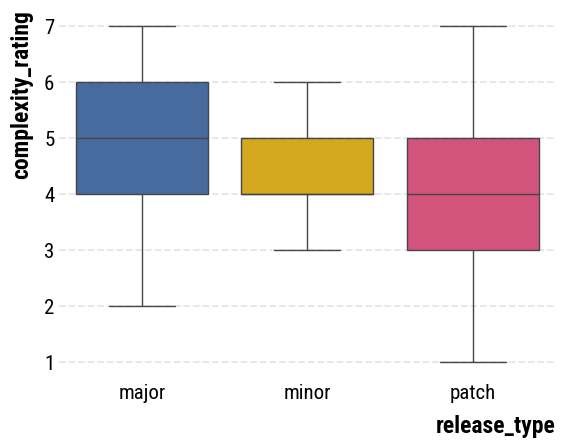

In [3]:
# Create boxplot for release-type by complexity-rating
sns.boxplot(
    df.filter(pl.col("release_type").is_in(["major", "minor", "patch"])).sort(
        "release_type"
    ),
    x="release_type",
    y="complexity_rating",
    showfliers=False,
    hue="release_type",
    hue_order=["major", "minor", "patch"],
)

In [4]:
def compute_anova_and_post_hocs_for_language(
    data: pl.DataFrame,
    language: str,
) -> None:
    # One way ANOVA for ecosystem
    distributions = {
        release_type: data.filter(pl.col("repo_language").eq(pl.lit(language)))
        .filter(pl.col("release_type").eq(pl.lit(release_type)))
        .select(pl.col("complexity_rating"))
        .get_column("complexity_rating")
        .to_numpy()
        for release_type in ["major", "minor", "patch"]
    }

    result = f_oneway(*distributions.values())
    print(result)

    if result.pvalue < 0.05:
        print("Distributions are significantly different")
        print()

        # Conduct pairwise t-tests
        for release_type1, release_type2 in combinations(distributions.keys(), 2):
            post_hoc_result = ttest_ind(
                distributions[release_type1],
                distributions[release_type2],
            )

            if post_hoc_result.pvalue < 0.05:
                print(release_type1, release_type2, post_hoc_result)
                print(
                    release_type1,
                    round(distributions[release_type1].mean(), 3),
                    round(distributions[release_type1].std(), 3),
                )
                print(
                    release_type2,
                    round(distributions[release_type2].mean(), 3),
                    round(distributions[release_type2].std(), 3),
                )


# Compute ANOVA and post hocs for each ecosystem
for language in ["JavaScript", "Python", "Ruby"]:
    print(f"LANGUAGE: {language}")
    print()
    compute_anova_and_post_hocs_for_language(
        data=df,
        language=language,
    )
    print()
    print("-" * 80)

LANGUAGE: JavaScript

F_onewayResult(statistic=np.float64(35.49211048739932), pvalue=np.float64(2.6279893235189308e-14))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(4.859506126888104), pvalue=np.float64(2.5303623813053966e-06), df=np.float64(182.0))
major 4.739 1.02
minor 4.043 0.908
major patch TtestResult(statistic=np.float64(7.9913068160601135), pvalue=np.float64(2.427229715726054e-13), df=np.float64(161.0))
major 4.739 1.02
patch 3.408 1.082
minor patch TtestResult(statistic=np.float64(4.045406432773933), pvalue=np.float64(8.086267729502196e-05), df=np.float64(161.0))
minor 4.043 0.908
patch 3.408 1.082

--------------------------------------------------------------------------------
LANGUAGE: Python

F_onewayResult(statistic=np.float64(11.691008120815216), pvalue=np.float64(2.0520858711236012e-05))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(3.744110614169056), pvalue=np.float64(0.0003085906981

## Dependents

In [5]:
selected_columns = [
    col_name for col_name in df.columns if "num_dependents_" in col_name
]

# Calculate log difference in dependents
constructed_exprs = []
for col_name in selected_columns:
    # Ignore the 0 day
    if col_name == "num_dependents_on_release_date":
        continue

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                pl.when(pl.col("num_dependents_on_release_date").gt(pl.lit(0)))
                .then(
                    (
                        pl.col(col_name).log()
                        - pl.col("num_dependents_on_release_date").log()
                    )
                )
                .otherwise(
                    pl.lit(0),
                )
            ).alias(f"log_difference_dependents_{timedelta_int}_days")
        )

# Create new column for log difference dependents
log_diff_dependents_ecosystem_release_type = (
    df.filter(pl.col("repo_language").is_in(["JavaScript", "Python", "Ruby"]))
    .filter(pl.col("release_type") != "unknown")
    .filter(pl.col("num_dependents_on_release_date").gt(pl.lit(1)))
    .select(
        pl.col("repository_uuid"),
        pl.col("release_version"),
        pl.col("release_major_version"),
        pl.col("repo_language"),
        pl.col("release_type"),
        pl.col("complexity_rating"),
        # Quantile bins for num_dependents
        pl.col("num_dependents_on_release_date")
        .qcut(
            [0.25, 0.75],
            labels=["bottom-25", "middle-50", "top-25"],
        )
        .over("repo_language")
        .alias("num_dependents_quantile"),
        # Version series bins
        pl.when(
            pl.col("release_type").is_in(["zero-major", "zero-minor"]),
        )
        .then(pl.lit("zero-ver"))
        .when(
            pl.col("release_major_version").eq(pl.lit(1)),
        )
        .then(pl.lit("one-ver"))
        .otherwise(pl.lit("two-plus-ver"))
        .alias("version_series"),
        *constructed_exprs,
    )
    .unpivot(
        index=[
            "repository_uuid",
            "repo_language",
            "release_type",
            "release_version",
            "release_major_version",
            "num_dependents_quantile",
            "version_series",
            "complexity_rating",
        ],
        variable_name="days_since_release",
        value_name="log_difference_dependents",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(
            r"^(log_difference_dependents_)(\d+)(_days)$",
            r"$2",
        )
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
)

(212, 10)


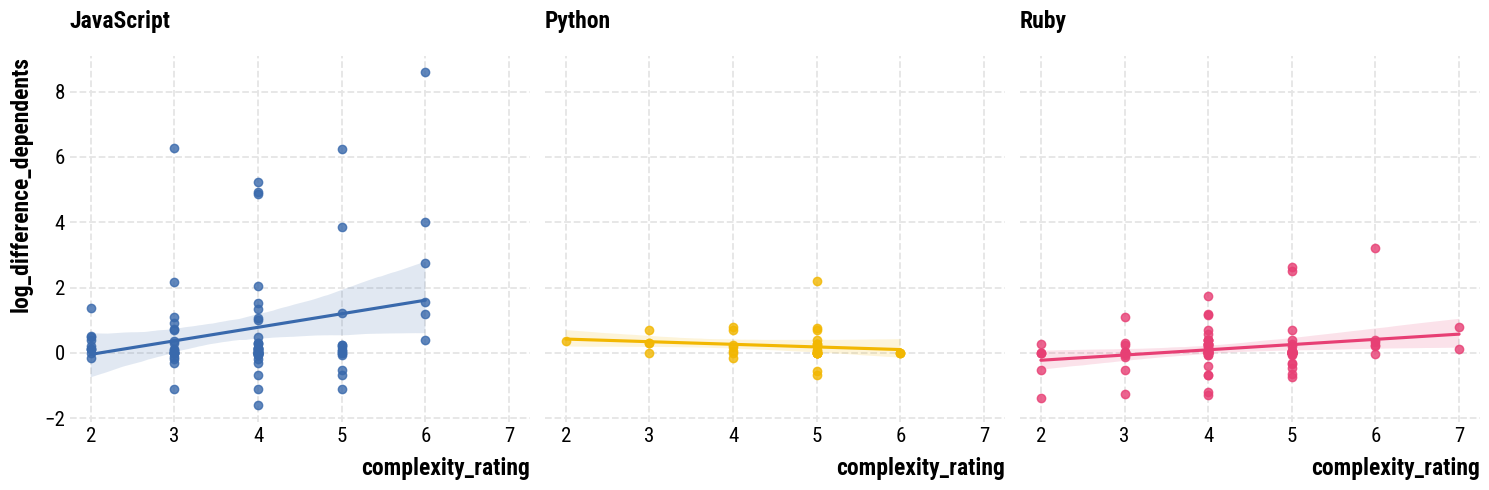

In [6]:
modeling_data = (
    log_diff_dependents_ecosystem_release_type.filter(
        pl.col("days_since_release").eq(pl.lit(360))
    )
    .filter(pl.col("log_difference_dependents").is_nan().not_())
    .filter(pl.col("log_difference_dependents").is_infinite().not_())
)

print(modeling_data.shape)

g = sns.lmplot(
    modeling_data,
    x="complexity_rating",
    y="log_difference_dependents",
    col="repo_language",
    col_order=["JavaScript", "Python", "Ruby"],
    hue="repo_language",
    hue_order=["JavaScript", "Python", "Ruby"],
)

g.set_titles("{col_name}")

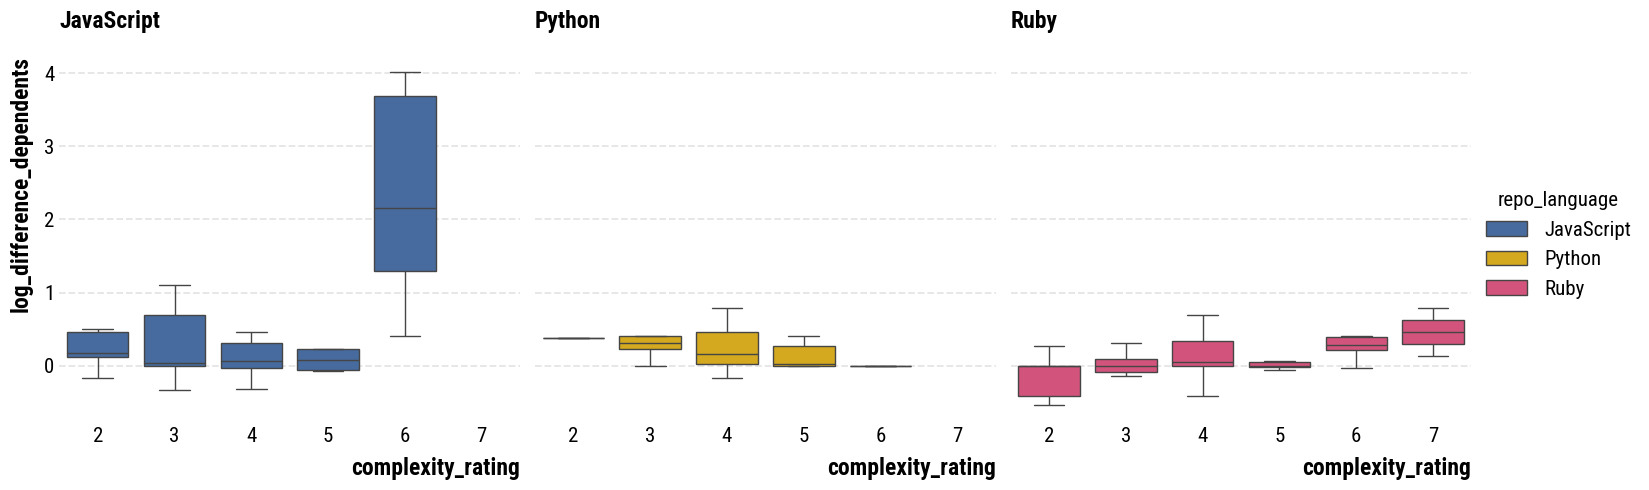

In [7]:
g = sns.catplot(
    modeling_data,
    x="complexity_rating",
    y="log_difference_dependents",
    col="repo_language",
    col_order=["JavaScript", "Python", "Ruby"],
    kind="box",
    showfliers=False,
    hue="repo_language",
    hue_order=["JavaScript", "Python", "Ruby"],
)

g.set_titles("{col_name}")

In [8]:
# Compute kendall tau correlation for each repo language
for language in ["JavaScript", "Python", "Ruby"]:
    print(f"LANGUAGE: {language}")
    print()
    lang_subset = modeling_data.filter(pl.col("repo_language").eq(pl.lit(language)))
    k_tau_result = kendalltau(
        lang_subset.get_column("complexity_rating").to_numpy(),
        lang_subset.get_column("log_difference_dependents").to_numpy(),
    )
    print("Kendall Result:", k_tau_result)
    spearman_result = spearmanr(
        lang_subset.get_column("complexity_rating").to_numpy(),
        lang_subset.get_column("log_difference_dependents").to_numpy(),
    )
    print("Spearman Result:", spearman_result)
    pearson_result = pearsonr(
        lang_subset.get_column("complexity_rating").to_numpy(),
        lang_subset.get_column("log_difference_dependents").to_numpy(),
    )
    print("Pearson Result:", pearson_result)
    print()
    print("-" * 80)

LANGUAGE: JavaScript

Kendall Result: SignificanceResult(statistic=np.float64(0.06158726965782516), pvalue=np.float64(0.44776523750839325))
Spearman Result: SignificanceResult(statistic=np.float64(0.08981711081507678), pvalue=np.float64(0.4052984098698921))
Pearson Result: PearsonRResult(statistic=np.float64(0.2542650922302422), pvalue=np.float64(0.016823439825566205))

--------------------------------------------------------------------------------
LANGUAGE: Python

Kendall Result: SignificanceResult(statistic=np.float64(-0.2998505318311938), pvalue=np.float64(0.034686414876118885))
Spearman Result: SignificanceResult(statistic=np.float64(-0.3709944297327824), pvalue=np.float64(0.03354151555305683))
Pearson Result: PearsonRResult(statistic=np.float64(-0.1550170941099952), pvalue=np.float64(0.3890215143106191))

--------------------------------------------------------------------------------
LANGUAGE: Ruby

Kendall Result: SignificanceResult(statistic=np.float64(0.12390488167559652), p